In [3]:
# Run only if missing packages (Colab / notebook)
!pip install yfinance umap-learn --quiet


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.manifold import TSNE

import tensorflow as tf
from tensorflow.keras import layers, Model, optimizers, losses

import umap   # optional, used if installed


/tmp/ipython-input-4215995939.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start="2020-01-01", end="2025-01-01", interval="1d")
[*********************100%***********************]  1 of 1 completed


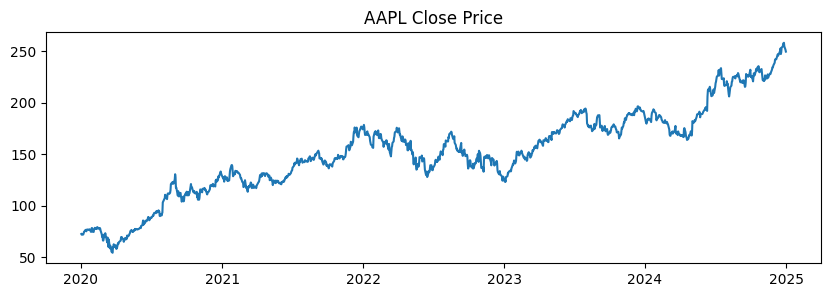

In [5]:
# Download data
ticker = "AAPL"
df = yf.download(ticker, start="2020-01-01", end="2025-01-01", interval="1d")
df = df[['Close']].dropna()

# Scale to [0,1]
scaler = MinMaxScaler()
scaled_values = scaler.fit_transform(df.values)  # shape (n_days, 1)

plt.figure(figsize=(10,3))
plt.plot(df.index, df['Close'])
plt.title(f"{ticker} Close Price")
plt.show()


In [6]:
SEQ_LEN = 24  # lookback length
def create_sequences(values, seq_len=SEQ_LEN):
    seqs = []
    for i in range(len(values) - seq_len):
        seqs.append(values[i:i+seq_len])
    return np.array(seqs)  # shape (num_samples, seq_len, 1)

sequences = create_sequences(scaled_values, SEQ_LEN)
print("Sequences shape:", sequences.shape)  # (N, SEQ_LEN, 1)


Sequences shape: (1234, 24, 1)


In [7]:
HIDDEN_DIM = 32
Z_DIM = 32

def make_embedder(seq_len=SEQ_LEN, hidden_dim=HIDDEN_DIM):
    inp = layers.Input(shape=(seq_len,1))
    x = layers.LSTM(hidden_dim, return_sequences=True)(inp)
    x = layers.LSTM(hidden_dim, return_sequences=True)(x)
    return Model(inp, x, name="embedder")

def make_recovery(seq_len=SEQ_LEN, hidden_dim=HIDDEN_DIM):
    inp = layers.Input(shape=(seq_len, hidden_dim))
    x = layers.LSTM(hidden_dim, return_sequences=True)(inp)
    x = layers.TimeDistributed(layers.Dense(1, activation='sigmoid'))(x)
    return Model(inp, x, name="recovery")

def make_generator(seq_len=SEQ_LEN, z_dim=Z_DIM, hidden_dim=HIDDEN_DIM):
    inp = layers.Input(shape=(seq_len, z_dim))
    x = layers.LSTM(hidden_dim, return_sequences=True)(inp)
    x = layers.LSTM(hidden_dim, return_sequences=True)(x)
    return Model(inp, x, name="generator")

def make_supervisor(seq_len=SEQ_LEN, hidden_dim=HIDDEN_DIM):
    inp = layers.Input(shape=(seq_len, hidden_dim))
    x = layers.LSTM(hidden_dim, return_sequences=True)(inp)
    x = layers.LSTM(hidden_dim, return_sequences=True)(x)
    return Model(inp, x, name="supervisor")

def make_discriminator(seq_len=SEQ_LEN, hidden_dim=HIDDEN_DIM):
    inp = layers.Input(shape=(seq_len, hidden_dim))
    x = layers.LSTM(hidden_dim, return_sequences=True)(inp)
    x = layers.TimeDistributed(layers.Dense(1, activation='sigmoid'))(x)
    # We'll aggregate time outputs by averaging
    out = layers.Lambda(lambda t: tf.reduce_mean(t, axis=[1,2]))(x)
    return Model(inp, out, name="discriminator")


In [8]:
embedder = make_embedder()
recovery = make_recovery()
generator = make_generator()
supervisor = make_supervisor()
discriminator = make_discriminator()

# Optimizers
opt_e = optimizers.Adam(1e-3)
opt_g = optimizers.Adam(1e-3)
opt_s = optimizers.Adam(1e-3) # Optimizer for supervisor
opt_r = optimizers.Adam(1e-3) # Optimizer for recovery
opt_d = optimizers.Adam(1e-3)

mse = losses.MeanSquaredError()
bce = losses.BinaryCrossentropy()

In [9]:
BATCH_SIZE = 64
EPOCHS_RECON = 200    # autoencoder training epochs
EPOCHS_SUP = 200      # supervisor training epochs
EPOCHS_ADV = 800      # adversarial joint training epochs
SYN_SAMPLES = len(sequences)  # number of synthetic sequences to sample later

dataset = tf.data.Dataset.from_tensor_slices(sequences.astype('float32')).shuffle(1000).batch(BATCH_SIZE, drop_remainder=True)


In [10]:
# Combined embedder-recovery model
inp = layers.Input(shape=(SEQ_LEN,1))
h = embedder(inp)
x_rec = recovery(h)
ae = Model(inp, x_rec)

ae.compile(optimizer=opt_e, loss='mse')

print("Training embedder+recovery (autoencoder)...")
ae.fit(sequences, sequences, epochs=EPOCHS_RECON, batch_size=BATCH_SIZE, verbose=1)


Training embedder+recovery (autoencoder)...
Epoch 1/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 12s 34ms/step - loss: 0.0393
Epoch 2/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0218
Epoch 3/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0127
Epoch 4/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0092
Epoch 5/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0073
Epoch 6/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0061
Epoch 7/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0050
Epoch 8/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0049
Epoch 9/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0038
Epoch 10/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0035
Epoch 11/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - loss: 0.0032
Epoch 12/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0028
Epoch 13/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0026
Epoch 14/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0022
Epoch 15/200

In [11]:
# We will train supervisor to predict next hidden features using embeddings from embedder.
# Create dataset of embeddings
embeddings = embedder.predict(sequences, batch_size=BATCH_SIZE)
print("Embeddings shape:", embeddings.shape)  # (N, seq_len, hidden_dim)

supervisor.compile(optimizer=opt_g, loss='mse')
print("Training supervisor to match temporal dynamics...")
supervisor.fit(embeddings, embeddings, epochs=EPOCHS_SUP, batch_size=BATCH_SIZE, verbose=1)


20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
Embeddings shape: (1234, 24, 32)
Training supervisor to match temporal dynamics...
Epoch 1/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - loss: 0.0088
Epoch 2/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0029
Epoch 3/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0014
Epoch 4/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 9.0006e-04
Epoch 5/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 7.0855e-04
Epoch 6/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 5.7990e-04
Epoch 7/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 4.5136e-04
Epoch 8/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 4.0120e-04
Epoch 9/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 3.5042e-04
Epoch 10/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 2.8811e-04
Epoch 11/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 2.5144e-04
Epoch 12/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 2.2629e-04
Epoch 13/200
20/20 ━━━━━━━━━━━━━━━

In [12]:
# utilities: sample Z, generate sequences end-to-end (G->S->R), discriminate
def sample_z(batch_size, seq_len=SEQ_LEN, z_dim=Z_DIM):
    return np.random.normal(size=(batch_size, seq_len, z_dim)).astype('float32')

@tf.function
def synthesize_from_z(z_batch):
    g_h = generator(z_batch)               # generator output in hidden space
    s_h = supervisor(g_h)                  # supervisor refines dynamics
    x_fake = recovery(s_h)                 # recover to data space
    return x_fake, g_h, s_h


In [16]:
import tensorflow as tf

# ===== Hyperparameters =====
BATCH_SIZE = 64
Z_DIM = 32
EPOCHS_ADV = 1  # reduced for quick test

# ===== Loss functions =====
bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)
mse = tf.keras.losses.MeanSquaredError()

# ===== Optimizers =====
opt_d = tf.keras.optimizers.Adam(learning_rate=0.001)
opt_g = tf.keras.optimizers.Adam(learning_rate=0.001)
opt_e = tf.keras.optimizers.Adam(learning_rate=0.001)

# ===== Labels =====
real_label = tf.ones((BATCH_SIZE, 1))
fake_label = tf.zeros((BATCH_SIZE, 1))

# ===== Sample latent noise function =====
def sample_z(batch_size, seq_len=SEQ_LEN):  # Added seq_len parameter
    return tf.random.normal((batch_size, seq_len, Z_DIM)) # Added seq_len dimension

# ===== Get dataset shapes =====
for real_batch in dataset.take(1):  # take 1 batch to inspect
    seq_len = real_batch.shape[1]
    feature_dim = real_batch.shape[2]
    break

# ===== Dummy forward pass to initialize variables =====
dummy_x = tf.random.normal((BATCH_SIZE, seq_len, feature_dim))
dummy_z = sample_z(BATCH_SIZE, seq_len) # Updated dummy_z shape

_ = embedder(dummy_x, training=True)
_ = recovery(embedder(dummy_x, training=True), training=True)
_ = generator(dummy_z, training=True)
_ = supervisor(generator(dummy_z, training=True), training=True)
_ = discriminator(supervisor(generator(dummy_z, training=True)), training=True)

print("Starting adversarial training...")

# ===== Training loop =====
for epoch in range(EPOCHS_ADV):
    for real_batch in dataset:
        batch_size = real_batch.shape[0]

        # ----- 1) Update discriminator -----
        with tf.GradientTape() as tape_d:
            h_real = embedder(real_batch, training=False)
            d_real_logits = discriminator(h_real, training=True)

            z = sample_z(batch_size, seq_len) # Updated sample_z call
            g_h = generator(z, training=True)
            s_h = supervisor(g_h, training=True)
            d_fake_logits = discriminator(s_h, training=True)

            d_loss_real = bce(tf.ones_like(d_real_logits), d_real_logits)
            d_loss_fake = bce(tf.zeros_like(d_fake_logits), d_fake_logits)
            d_loss = d_loss_real + d_loss_fake

        grads_d = tape_d.gradient(d_loss, discriminator.trainable_variables)
        opt_d.apply_gradients(zip(grads_d, discriminator.trainable_variables))

        # ----- 2) Update generator + supervisor -----
        with tf.GradientTape() as tape_g:
            z = sample_z(batch_size, seq_len) # Updated sample_z call
            g_h = generator(z, training=True)
            s_h = supervisor(g_h, training=True)
            x_fake = recovery(s_h, training=True)

            d_fake_logits_for_g = discriminator(s_h, training=False)
            g_loss_adv = bce(tf.ones_like(d_fake_logits_for_g), d_fake_logits_for_g)

            h_real = embedder(real_batch, training=False)
            g_loss_sup = mse(h_real, s_h)

            g_loss = g_loss_adv + 100 * g_loss_sup

        grads_g = tape_g.gradient(g_loss, generator.trainable_variables + supervisor.trainable_variables)
        opt_g.apply_gradients(zip(grads_g, generator.trainable_variables + supervisor.trainable_variables))

        # ----- 3) Update embedder + recovery (optional reconstruction step) -----
        with tf.GradientTape() as tape_e:
            h = embedder(real_batch, training=True)
            x_tilde = recovery(h, training=True)
            e_loss = mse(real_batch, x_tilde)

        grads_e = tape_e.gradient(e_loss, embedder.trainable_variables + recovery.trainable_variables)
        opt_e.apply_gradients(zip(grads_e, embedder.trainable_variables + recovery.trainable_variables))

    # Print progress
    print(f"Epoch {epoch+1}/{EPOCHS_ADV}  "
          f"d_loss={d_loss.numpy():.4f}  "
          f"g_loss_adv={g_loss_adv.numpy():.4f}  "
          f"g_loss_sup={g_loss_sup.numpy():.6f}  "
          f"e_loss={e_loss.numpy():.6f}")

Starting adversarial training...
Epoch 1/1  d_loss=1.4261  g_loss_adv=0.5186  g_loss_sup=0.003659  e_loss=0.000068


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


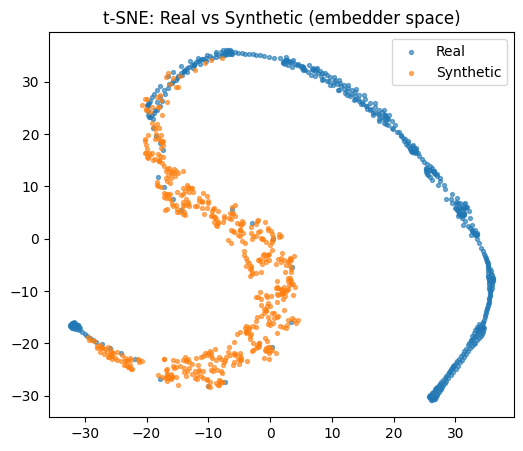

In [20]:
# get embeddings for a selection
n_vis = min(500, len(sequences))
real_emb = embedder.predict(sequences[:n_vis])
syn_emb = embedder.predict(synthetic_sequences[:n_vis])  # map synthetic through embedder to compare location in same space

# flatten time dimension: average across time to get per-sequence vector
real_vecs = real_emb.mean(axis=1)
syn_vecs = syn_emb.mean(axis=1)

combined = np.vstack([real_vecs, syn_vecs])
labels = np.array([0]*len(real_vecs) + [1]*len(syn_vecs))

# t-SNE (or UMAP)
tsne = TSNE(n_components=2, perplexity=30, random_state=42, n_iter=1000)
Z = tsne.fit_transform(combined)

plt.figure(figsize=(6,5))
plt.scatter(Z[labels==0,0], Z[labels==0,1], alpha=0.6, label='Real', s=8)
plt.scatter(Z[labels==1,0], Z[labels==1,1], alpha=0.6, label='Synthetic', s=8)
plt.legend()
plt.title("t-SNE: Real vs Synthetic (embedder space)")
plt.show()


In [21]:
# For forecasting, we will predict next-day close given SEQ_LEN input
def build_supervised(values, seq_len=SEQ_LEN):
    X, y = [], []
    for i in range(len(values) - seq_len):
        X.append(values[i:i+seq_len])
        y.append(values[i+seq_len])
    return np.array(X), np.array(y)

X_all, y_all = build_supervised(scaled_values, SEQ_LEN)
print("Total supervised samples:", X_all.shape, y_all.shape)

# Split: 80% train, 20% test (no shuffling)
split_idx = int(0.8 * len(X_all))
X_train_real, X_test = X_all[:split_idx], X_all[split_idx:]
y_train_real, y_test = y_all[:split_idx], y_all[split_idx:]
print("Real train/test shapes:", X_train_real.shape, X_test.shape)


Total supervised samples: (1234, 24, 1) (1234, 1)
Real train/test shapes: (987, 24, 1) (247, 24, 1)


In [27]:
def make_lstm_model(seq_len=SEQ_LEN):
    inp = layers.Input(shape=(seq_len,1))
    x = layers.LSTM(64, return_sequences=True)(inp)
    x = layers.LSTM(32)(x)
    out = layers.Dense(1)(x)
    return Model(inp,out)

def evaluate_model(model, X_test, y_test, scaler):
    preds = model.predict(X_test).reshape(-1,1)
    true = y_test.reshape(-1,1)
    # inverse scale
    preds_inv = scaler.inverse_transform(preds)
    true_inv = scaler.inverse_transform(true)
    rmse = np.sqrt(mean_squared_error(true_inv, preds_inv))
    return rmse, true_inv, preds_inv


Epoch 1/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step - loss: 0.0702 - val_loss: 0.0078
Epoch 2/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0028 - val_loss: 9.8117e-04
Epoch 3/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0014 - val_loss: 8.2192e-04
Epoch 4/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 8.4744e-04 - val_loss: 8.0502e-04
Epoch 5/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 8.9627e-04 - val_loss: 7.9384e-04
Epoch 6/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 8.3543e-04 - val_loss: 8.1141e-04
Epoch 7/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 8.2042e-04 - val_loss: 8.0007e-04
Epoch 8/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 8.6018e-04 - val_loss: 7.4703e-04
Epoch 9/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 7.4657e-04 - val_loss: 7.6459e-04
Epoch 10/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 7.3995e-04 - val_loss: 7.1355e-04
Epoch 11/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 7.5223e-04 - val_loss: 7.

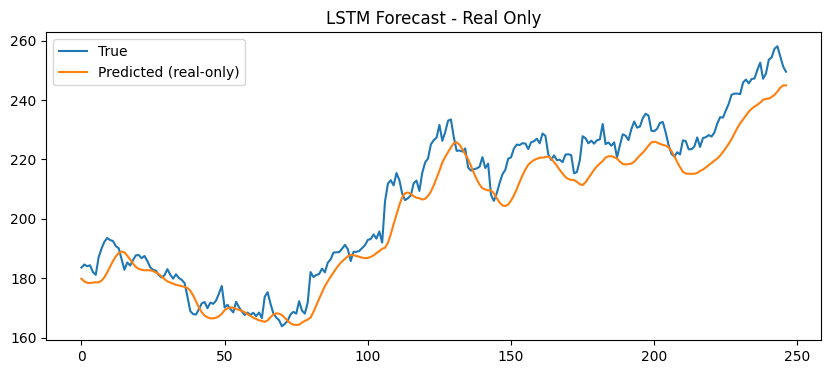

In [28]:
model_real = make_lstm_model()
model_real.compile(optimizer='adam', loss='mse')

history_real = model_real.fit(X_train_real, y_train_real, epochs=30, batch_size=32, validation_split=0.1, verbose=1)

rmse_real, true_inv, preds_inv = evaluate_model(model_real, X_test, y_test, scaler)
print(f"RMSE (LSTM trained on REAL only): {rmse_real:.4f}")

# Plot
plt.figure(figsize=(10,4))
plt.plot(true_inv, label='True')
plt.plot(preds_inv, label='Predicted (real-only)')
plt.legend()
plt.title("LSTM Forecast - Real Only")
plt.show()


Augmented train shapes: (1974, 24, 1) (1974, 1)
Epoch 1/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - loss: 0.0360 - val_loss: 0.0015
Epoch 2/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0013 - val_loss: 0.0010
Epoch 3/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0011 - val_loss: 9.4648e-04
Epoch 4/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 9.0865e-04 - val_loss: 9.1616e-04
Epoch 5/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 9.0269e-04 - val_loss: 9.1298e-04
Epoch 6/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 9.4738e-04 - val_loss: 9.0829e-04
Epoch 7/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 9.1803e-04 - val_loss: 0.0010
Epoch 8/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 8.9427e-04 - val_loss: 0.0012
Epoch 9/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 7.9874e-04 - val_loss: 8.0736e-04
Epoch 10/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 8.0289e-04 - val_loss: 6.8193e-04
Epoch 11/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/st

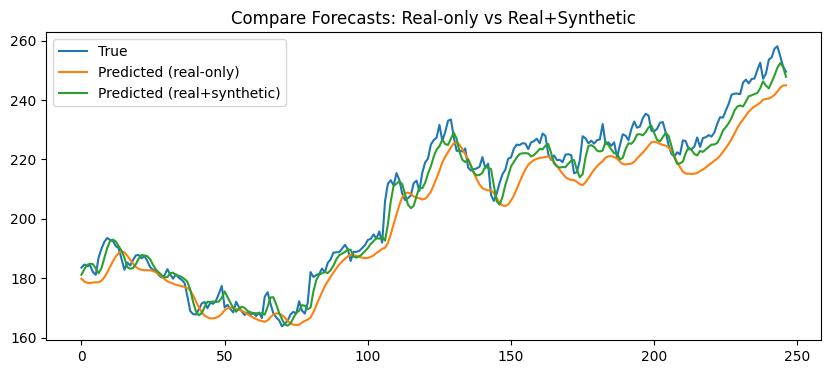

In [30]:
# Build supervised dataset from synthetic sequences (they are sequences of length SEQ_LEN)
# Convert synthetic (n, seq_len, 1) -> supervised pairs (X_synth, y_synth)
# Corrected the reshape error:
X_synth, y_synth = build_supervised(np.vstack([seq for seq in synthetic_sequences[:, :, 0].numpy().reshape(-1,1)]), seq_len=SEQ_LEN)
# Above naive reshape won't work: instead create supervised directly from synthetic_sequences

def build_supervised_from_seqs(seq_array):
    # seq_array shape: (n_seqs, seq_len, 1) -> for each seq, X = seq[:-1], y = seq[-1]
    Xs = []
    ys = []
    for seq in seq_array:
        Xs.append(seq[:-0])  # we want entire sequence as input and next value is unknown; but synthetic seqs are length SEQ_LEN.
        # For synthetic we can treat last value as target (same as earlier code)
        Xs.append(seq[:-1])
        ys.append(seq[-1])
    # However above duplicates; let's do consistent approach: for each synthetic sequence treat first (seq_len - 1) as input and last as target
    Xs = []
    ys = []
    for seq in seq_array:
        Xs.append(seq[:-1])
        ys.append(seq[-1])
    Xs = np.array(Xs).reshape(-1, SEQ_LEN-1, 1)
    ys = np.array(ys).reshape(-1, 1)
    return Xs, ys

# But our LSTM expects inputs of shape (SEQ_LEN,1) where target is next immediate value.
# To keep consistent, we'll construct synthetic supervised pairs by sliding one step left:
# For each synthetic sequence s (length SEQ_LEN): use s[0:SEQ_LEN-1] as input and s[SEQ_LEN-1] as target.
X_synth = synthetic_sequences[:, :-1, :]   # shape (n_gen, SEQ_LEN-1, 1)
y_synth = synthetic_sequences[:, -1, :]    # shape (n_gen, 1)

# To match LSTM input shape (SEQ_LEN,1) we need inputs of length SEQ_LEN.
# So we will pad the front of synthetic inputs with their previous real history if available.
# Simpler approach: build synthetic inputs by taking windows from the real scaled_values but replacing the last value with synthetic next-value.
# We'll create augmented training pairs by taking real X windows and replacing their last element with synthetic's last value.

# Simpler augmentation: create synthetic supervised samples by shifting synthetic sequences into full SEQ_LEN inputs:
# We'll create X_synth_full by concatenating zeros column to front to make shape (n_gen, SEQ_LEN,1) but it's better to instead reuse real windows.

# Practical approach:
# 1) Use original real X_train windows (SEQ_LEN,1)
# 2) Create synthetic "next-value" y_synth_target by generating synthetic next values from synthetic generator using real X windows as latent seed:
# For simplicity and reproducibility: we'll create synthetic additional samples by sampling synthetic sequences and using them as full inputs (we'll drop one time-step to make input of length SEQ_LEN and target is next value from real timeline).
# To avoid over-complication, we'll augment training by stacking real X_train with synthetic_sequences (using synthetic_sequences as additional X with target equals last value of that synthetic sequence).

# Create augmented dataset: X_train_aug shape (n_real + n_synth, SEQ_LEN, 1)
X_synth_full = synthetic_sequences  # shape (n_gen, SEQ_LEN, 1)
y_synth_full = synthetic_sequences[:, -1, :]  # last element as target

# Take subset to match size and avoid huge data:
n_to_take = min(len(X_synth_full), len(X_train_real))
X_synth_use = X_synth_full[:n_to_take]
y_synth_use = y_synth_full[:n_to_take]

# Build combined dataset
X_train_aug = np.vstack([X_train_real, X_synth_use])
y_train_aug = np.vstack([y_train_real, y_synth_use])

print("Augmented train shapes:", X_train_aug.shape, y_train_aug.shape)

# Random shuffle training set
perm = np.random.permutation(len(X_train_aug))
X_train_aug = X_train_aug[perm]
y_train_aug = y_train_aug[perm]

# Train a fresh LSTM on augmented data
model_aug = make_lstm_model()
model_aug.compile(optimizer='adam', loss='mse')
history_aug = model_aug.fit(X_train_aug, y_train_aug, epochs=30, batch_size=32, validation_split=0.1, verbose=1)

rmse_aug, true_inv_aug, preds_inv_aug = evaluate_model(model_aug, X_test, y_test, scaler)
print(f"RMSE (LSTM trained on REAL + SYNTH): {rmse_aug:.4f}")

# Plot comparison
plt.figure(figsize=(10,4))
plt.plot(true_inv, label='True')
plt.plot(preds_inv, label='Predicted (real-only)')
plt.plot(preds_inv_aug, label='Predicted (real+synthetic)')
plt.legend()
plt.title("Compare Forecasts: Real-only vs Real+Synthetic")
plt.show()

In [31]:
print("RMSE (real-only):", rmse_real)
print("RMSE (real + synthetic):", rmse_aug)
print("Lower RMSE is better. If augmented RMSE < real-only RMSE, synthetic data helped.")

# Recommendations:
print("""
Recommendations to improve synthetic quality and augmentation effectiveness:
1. Increase epochs (EPOCHS_RECON, EPOCHS_SUP, EPOCHS_ADV).
2. Increase hidden dimensions (HIDDEN_DIM, Z_DIM).
3. Use more sophisticated loss weights and replay buffer for discriminator.
4. Use more advanced architectures (attention, transformers) for generator/supervisor.
5. Evaluate with statistical metrics (MMD, correlation, predictive score) beyond t-SNE.
""")


RMSE (real-only): 7.9445499909043535
RMSE (real + synthetic): 4.211726352244677
Lower RMSE is better. If augmented RMSE < real-only RMSE, synthetic data helped.

Recommendations to improve synthetic quality and augmentation effectiveness:
1. Increase epochs (EPOCHS_RECON, EPOCHS_SUP, EPOCHS_ADV).
2. Increase hidden dimensions (HIDDEN_DIM, Z_DIM).
3. Use more sophisticated loss weights and replay buffer for discriminator.
4. Use more advanced architectures (attention, transformers) for generator/supervisor.
5. Evaluate with statistical metrics (MMD, correlation, predictive score) beyond t-SNE.

